# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-kvsbqvha
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-kvsbqvha
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit ce82675a8e89b6d5e6229a89620c843c794f3b04
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 796.8 kB/s eta 0:00:00
    

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

## Load Model

In [5]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# get preds fn

In [7]:
def remove_batch_dim(
    tensor: Float[torch.Tensor, "1 ..."]
) -> Float[torch.Tensor, "..."]:
    """
    Removes the first dimension of a tensor if it is size 1, otherwise returns the tensor unchanged
    """
    if tensor.shape[0] == 1:
        return tensor.squeeze(0)
    else:
        return tensor

In [11]:
def get_top_preds(
    prompt: str,
    answer: str,
    model,  # Can't give type hint due to circular imports
    prepend_space_to_answer: Optional[bool] = True,
    print_details: Optional[bool] = True,
    prepend_bos: Optional[bool] = True, # key change
    top_k: Optional[int] = 10,
) -> None:
    """
    Args:
        prompt:
            The prompt string, e.g. "Why did the elephant cross the".
        answer:
            The answer, e.g. "road". Note that if you set prepend_space_to_answer to False, you need
            to think about if you have a space before the answer here (as e.g. in this example the
            answer may really be " road" if the prompt ends without a trailing space).
        model:
            The model.
        prepend_space_to_answer:
            Whether or not to prepend a space to the answer. Note this will only ever prepend a
            space if the answer doesn't already start with one.
        print_details:
            Print the prompt (as a string but broken up by token), answer and top k tokens (all
            with logit, rank and probability).
        prepend_bos:
            Overrides self.cfg.default_prepend_bos if set. Whether to prepend
            the BOS token to the input (applicable when input is a string). Models generally learn
            to use the BOS token as a resting place for attention heads (i.e. a way for them to be
            "turned off"). This therefore often improves performance slightly.
        top_k:
            Top k tokens to print details of (when print_details is set to True).

    Returns:
        None (just prints the results directly).
    """
    if prepend_space_to_answer and not answer.startswith(" "):
        answer = " " + answer
    # GPT-2 often treats the first token weirdly, so lets give it a resting position
    prompt_tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
    answer_tokens = model.to_tokens(answer, prepend_bos=False)
    tokens = torch.cat((prompt_tokens, answer_tokens), dim=1)
    prompt_str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)
    answer_str_tokens = model.to_str_tokens(answer, prepend_bos=False)
    prompt_length = len(prompt_str_tokens)
    answer_length = len(answer_str_tokens)
    # if print_details:
    #     print("Tokenized prompt:", prompt_str_tokens)
    #     print("Tokenized answer:", answer_str_tokens)
    logits = remove_batch_dim(model(tokens))  # key change
    # logits = remove_batch_dim(model(prompt_tokens))  # key change
    probs = logits.softmax(dim=-1)

    # key changes
    # logits = logits[0]
    # probs = probs[0]

    answer_ranks = []

    # from end of input to how long answer is (if answer is 1 token, this is just 1)
    for index in range(prompt_length, prompt_length + answer_length):
        answer_token = tokens[0, index]
        answer_str_token = answer_str_tokens[index - prompt_length]
        # Offset by 1 because models predict the NEXT token
        token_probs = probs[index - 1]
        sorted_token_probs, sorted_token_values = token_probs.sort(descending=True)
        # Janky way to get the index of the token in the sorted list - I couldn't find a better way?
        correct_rank = torch.arange(len(sorted_token_values))[
            (sorted_token_values == answer_token).cpu()
        ].item()
        answer_ranks.append((answer_str_token, correct_rank))
        # if print_details:
        #     # String formatting syntax - the first number gives the number of characters to pad to, the second number gives the number of decimal places.
        #     # rprint gives rich text printing
        #     print(
        #         f"Performance on answer token:\n[b]Rank: {correct_rank: <8} Logit: {logits[index-1, answer_token].item():5.2f} Prob: {token_probs[answer_token].item():6.2%} Token: |{answer_str_token}|[/b]"
        #     )
        #     for i in range(top_k):
        #         print(
        #             f"Top {i}th token. Logit: {logits[index-1, sorted_token_values[i]].item():5.2f} Prob: {sorted_token_probs[i].item():6.2%} Token: |{model.to_string(sorted_token_values[i])}|"
        #         )
    # print(f"[b]Ranks of the answer tokens:[/b] {answer_ranks}")

    return logits[index-1, sorted_token_values[:top_k]], sorted_token_probs[:top_k], [model.to_string(tok) for tok in sorted_token_values[:top_k]]

# Numeric, decr

In [8]:
example_prompt = "5 4 3 2"
example_answer = " 1"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '5', ' 4', ' 3', ' 2']
Tokenized answer: [' 1']


Performance on answer token:
Rank: 0        Logit: 17.47 Prob: 48.35% Token: | 1|

Top 0th token. Logit: 17.47 Prob: 48.35% Token: | 1|
Top 1th token. Logit: 16.10 Prob: 12.34% Token: | 2|
Top 2th token. Logit: 15.90 Prob: 10.12% Token: | 0|
Top 3th token. Logit: 15.43 Prob:  6.31% Token: | 3|
Top 4th token. Logit: 14.73 Prob:  3.14% Token: |
|
Top 5th token. Logit: 14.32 Prob:  2.07% Token: |.|
Top 6th token. Logit: 13.90 Prob:  1.36% Token: | 5|
Top 7th token. Logit: 13.82 Prob:  1.26% Token: | 4|
Top 8th token. Logit: 13.80 Prob:  1.24% Token: | .|
Top 9th token. Logit: 13.48 Prob:  0.90% Token: | -|


Ranks of the answer tokens: [(' 1', 0)]

In [44]:
# for every prompt, get its top token. find which top tokens are S4 + 1

prompt = "1 second passed. Then 2 seconds. Next 3 seconds. Then 4 seconds. Finally"
answer = " 5"

logs, probs, toks = get_top_preds(
    prompt = prompt,
    answer = answer,
    model = model,
)
logs

tensor([15.9796, 15.9074, 15.6687, 15.5836, 15.4298, 15.2030, 14.5341, 14.2668,
        14.0130, 13.8063])

In [45]:
toks

[' 5', ',', ' 4', ' 3', ' 2', ' 1', ' 6', '.', ' 10', ' a']

In [46]:
toks.index(' 4')

2

In [47]:
incor_ind = toks.index(' 4')
logs[0] - logs[incor_ind]

tensor(0.3109)

In [20]:
prompt = "1 second passed. Then 2 seconds. Next 3 seconds. Then 4 seconds. Finally"
answer = " 5"
utils.test_prompt(prompt, answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' second', ' passed', '.', ' Then', ' 2', ' seconds', '.', ' Next', ' 3', ' seconds', '.', ' Then', ' 4', ' seconds', '.', ' Finally']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 15.98 Prob: 15.30% Token: | 5|

Top 0th token. Logit: 15.98 Prob: 15.30% Token: | 5|
Top 1th token. Logit: 15.91 Prob: 14.23% Token: |,|
Top 2th token. Logit: 15.67 Prob: 11.21% Token: | 4|
Top 3th token. Logit: 15.58 Prob: 10.30% Token: | 3|
Top 4th token. Logit: 15.43 Prob:  8.83% Token: | 2|
Top 5th token. Logit: 15.20 Prob:  7.04% Token: | 1|
Top 6th token. Logit: 14.53 Prob:  3.60% Token: | 6|
Top 7th token. Logit: 14.27 Prob:  2.76% Token: |.|
Top 8th token. Logit: 14.01 Prob:  2.14% Token: | 10|
Top 9th token. Logit: 13.81 Prob:  1.74% Token: | a|


Ranks of the answer tokens: [(' 5', 0)]

In [21]:
prompt = "1 second passed. Then 2. Next 3 seconds passed. Then 4 seconds. Finally"
answer = " 5"
utils.test_prompt(prompt, answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', '1', ' second', ' passed', '.', ' Then', ' 2', '.', ' Next', ' 3', ' seconds', ' passed', '.', ' Then', ' 4', ' seconds', '.', ' Finally']
Tokenized answer: [' 5']


Performance on answer token:
Rank: 0        Logit: 16.09 Prob: 31.66% Token: | 5|

Top 0th token. Logit: 16.09 Prob: 31.66% Token: | 5|
Top 1th token. Logit: 15.19 Prob: 12.77% Token: |,|
Top 2th token. Logit: 14.48 Prob:  6.31% Token: | 4|
Top 3th token. Logit: 14.22 Prob:  4.86% Token: | 1|
Top 4th token. Logit: 14.17 Prob:  4.63% Token: | 6|
Top 5th token. Logit: 14.10 Prob:  4.29% Token: | 3|
Top 6th token. Logit: 13.90 Prob:  3.53% Token: | 2|
Top 7th token. Logit: 13.70 Prob:  2.88% Token: |.|
Top 8th token. Logit: 13.25 Prob:  1.85% Token: | 10|
Top 9th token. Logit: 13.20 Prob:  1.75% Token: | a|


Ranks of the answer tokens: [(' 5', 0)]

# dataset

In [41]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'incor': f" {i+3}",
            'text': f"{i} seconds passed. Then {i+1} seconds. Next {i+2} seconds. Then {i+3} seconds. Finally",
            'answer': f" {i+4}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(2, 101)

In [49]:
logit_diffs = []
good_prompts = []

for prompt_dict in prompts_list:
    prompt = prompt_dict['text']
    answer = prompt_dict['answer']
    incor = prompt_dict['incor']

    logs, probs, toks = get_top_preds(
        prompt = prompt,
        answer = answer,
        model = model,
    )
    if toks[0] == answer:
        print(f"{prompt} -> {answer}", toks[0])
        incor_ind = toks.index(incor)
        l_diff = logs[0] - logs[incor_ind]
        logit_diffs.append(l_diff.item())
        print(l_diff.item())
        good_prompts.append(prompt)

4 seconds passed. Then 5 seconds. Next 6 seconds. Then 7 seconds. Finally ->  8  8
0.6241788864135742
5 seconds passed. Then 6 seconds. Next 7 seconds. Then 8 seconds. Finally ->  9  9
1.0272293090820312
6 seconds passed. Then 7 seconds. Next 8 seconds. Then 9 seconds. Finally ->  10  10
0.9744157791137695
7 seconds passed. Then 8 seconds. Next 9 seconds. Then 10 seconds. Finally ->  11  11
0.24978256225585938
8 seconds passed. Then 9 seconds. Next 10 seconds. Then 11 seconds. Finally ->  12  12
1.3463668823242188
9 seconds passed. Then 10 seconds. Next 11 seconds. Then 12 seconds. Finally ->  13  13
0.9000473022460938
10 seconds passed. Then 11 seconds. Next 12 seconds. Then 13 seconds. Finally ->  14  14
1.3127861022949219
11 seconds passed. Then 12 seconds. Next 13 seconds. Then 14 seconds. Finally ->  15  15
2.04351806640625
12 seconds passed. Then 13 seconds. Next 14 seconds. Then 15 seconds. Finally ->  16  16
1.7002592086791992
13 seconds passed. Then 14 seconds. Next 15 seconds

In [50]:
len(good_prompts) / len(prompts_list)

0.8585858585858586

Text(0.5, 1.0, 'Distribution of logit_diffs')

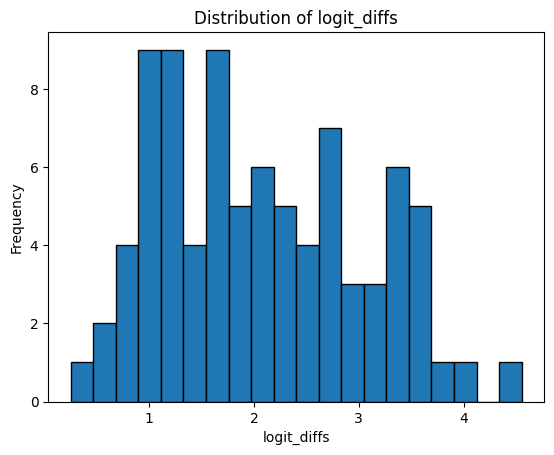

In [53]:
import matplotlib.pyplot as plt

# Creating a histogram for the scores
plt.hist(logit_diffs, bins = 20, edgecolor='black')  # Adjust the number of bins as needed

# Adding labels and title for clarity
plt.xlabel('logit_diffs')
plt.ylabel('Frequency')
plt.title('Distribution of logit_diffs')